#                 Choosing the best neighborhood to move to in Toronto 

Description Miguel lives in the North-West side of Toronto in Downsview where he enjoys what his neighbourhood has to offer, such as bars, restaurants, cafes and parks. He recently received a job offer in South-East Toronto at the Studio District, the career prospects at this new company represent what he was looking for and he is interested in taking this job. The problem is Miguel now has to move closer to his new job as commuting if not feasible from the place he lives as the salary is high enough he is not concerned about the rent prices, he is just focused on his social life thus venues and facilities nearby is what is the most important for him. There are plenty of options in the surrounding areas but he would like to choose the perfect location with venues similar to the ones of his neighbourhood.

To solve this problem Miguel is thinking about getting a list of all the possible neighborhoods in the city where he can move to, data regarding to the venues and facilities. This data will be taken from Foursquare where he will pull all the venues for each neighbourhood on Miguel’s options. Based on this data, he will build a classification model to help him determine the most suitable location for him. Venues data: https://foursquare.com/


In [227]:
import pandas as pd
import numpy as np


#### Neighborhood Grouping
The data corresponding to the neighborhoods in Toronto is taken from Wikipedia. The data extracted is then cleaned and each neighborhood is grouped according to its respective Postal Code

Data Source: wikipedia


In [228]:
#Read file
dfs =  pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
#Get relevant dataframe
df = dfs[0]
#Remove not assigned
df = df[df['Borough'] != 'Not assigned']
#Group the data
df_grouped = df.groupby(['Postal code','Borough'])['Neighborhood'].apply(','.join).reset_index()
df_grouped['Neighborhood']= df_grouped['Neighborhood'].str.replace('/',',')
#Print head
df_grouped.head()

,Postal code,Borough,Neighborhood
0,M1B,Scarborough,"Malvern , Rouge"
1,M1C,Scarborough,"Rouge Hill , Port Union , Highland Creek"
2,M1E,Scarborough,"Guildwood , Morningside , West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


#### Exploring Miguel's Neighborhood

Downsview is located in the north west part of Toronto and Studio District in the south east part of the city


In [245]:

import folium



map = folium.Map(location=[43.761631,-79.520999], zoom_start=11)
folium.Marker([43.761631,-79.520999], popup='Downsview').add_to(map)
folium.Marker([43.659526,-79.340923], popup='Studio District').add_to(map)
map


Four postal codes correspond to Downsview

In [230]:
#Rename the table
df_grouped = df_grouped.rename(columns = {'Postal code': 'Postal Code'})

#Read csv and join data
geo_data = pd.read_csv(r'H:\Python\Coursera\Data Analysis\Geospatial_Coordinates.csv')
df_geo = pd.merge(df_grouped, geo_data, on = 'Postal Code', how = 'left')
df_geo.head()

df_geo[df_geo['Neighborhood']=='Downsview']

,Postal Code,Borough,Neighborhood,Latitude,Longitude
30,M3K,North York,Downsview,43.737473,-79.464763
31,M3L,North York,Downsview,43.739015,-79.506944
32,M3M,North York,Downsview,43.728496,-79.495697
33,M3N,North York,Downsview,43.761631,-79.520999


### Extracting data from Foursquare 

Location data is data describing places and venues, such as their geographical location, their category, working hours, full address, and so on, such that for a given location given in the form of its geographical coordinates (or latitude and longitude values) one is able to determine what types of venues exist within a defined radius from that location. So, for a given location you will be able to tell if restaurants for example, exist nearby, or if schools, or parks, or gyms, or community centres exist nearby. Also, how many of each category exist and how each surrounding venue is reviewed by other people. So this is what's referred to as location data for this project Foursquare will be chosen fetch the Data, but what is Foursquare?

Foursquare is a technology company that built a massive dataset of location data. What is interesting about Foursquare is that they were very smart about building their dataset. They actually crowd-sourced their data and had people use their app to build their dataset and add venues and complete any missing information they had in their dataset. Currently its location data is the most comprehensive out there, and quite accurate that it powers location data for many popular services like Apple Maps, Uber, Snapchat, Twitter and many others, and is currently being used by over 100,000 developers, and this number is only growing.

The following map shows all the Postal Codes within Toronto that will be considered by Miguel


In [231]:
import folium

locations = df_geo[['Latitude', 'Longitude']]
locationlist = locations.values.tolist()



map = folium.Map(location=[43.651070, -79.347015], zoom_start=11)

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=df_geo['Postal Code'][point]).add_to(map)

map




In [232]:

import foursquare as fs
import requests # library to handle requests
import numpy as np # library to handle data in a vectorized manner 
import random # library for random number generation
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize


In [233]:
CLIENT_ID = 'B2A2O12OGUVOCNDPQGCJUMU343MXVSBXRWTOC3DUPJOB0FM1'
CLIENT_SECRET = 'YZDYE4QW1Z01QJXI0QGTDOD0SYV2JR24KBLA5NHR2NZLBMNQ'
LIMIT = 100
VERSION = '20200412'
client = fs.Foursquare(client_id= CLIENT_ID, client_secret = CLIENT_SECRET)

In [234]:



# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']



In [235]:
neighborhood_name = df_geo.loc[0,'Neighborhood']
neighborhood_latitude = df_geo.loc[0,'Latitude']
neighborhood_longitude = df_geo.loc[0,'Longitude']
LIMIT = 100
radius = 1000

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)


C:\Users\miguel.torres\.conda\envs\spyder\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


### Foursquare Data
After connecting to Foursquare's API the corresponding venues categories for each neighborhood were extracted as the sample below. 

In [236]:
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues

,name,categories,lat,lng
0,Wendy's,Fast Food Restaurant,43.802008,-79.198080
1,Wendy’s,Fast Food Restaurant,43.807448,-79.199056
2,Caribbean Wave,Caribbean Restaurant,43.798558,-79.195777
3,Harvey's,Restaurant,43.800020,-79.198307
4,Staples Morningside,Paper / Office Supplies Store,43.800285,-79.196607
5,Tim Hortons,Coffee Shop,43.802000,-79.198169
6,Lee Valley,Hobby Shop,43.803161,-79.199681
7,Tim Hortons / Esso,Coffee Shop,43.801863,-79.199296
8,MMA World Academy,Martial Arts Dojo,43.800259,-79.195227
9,Rouge Park - Woodland Trail,Trail,43.801782,-79.200427


In [237]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [238]:
neighborhood_name = df_geo.loc[0,'Neighborhood']
neighborhood_latitude = df_geo.loc[0,'Latitude']
neighborhood_longitude = df_geo.loc[0,'Longitude']


list_venues=getNearbyVenues(names=df_geo['Neighborhood'], latitudes=df_geo['Latitude'],
                    longitudes=df_geo['Longitude'])


### Exploring the Neighborgoods

Based on the data, Miguel now wants to see what are the neigborhoods with the lowest and the largest amount of venues within the city. 

In [239]:

neighborhood_venues_grouped = list_venues.groupby('Neighborhood').count()
neighborhood_venues_grouped.sort_values('Venue', ascending=False)


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Toronto Dominion Centre , Design Exchange",100,100,100,100,100,100
"Commerce Court , Victoria Hotel",100,100,100,100,100,100
"Harbourfront East , Union Station , Toronto Islands",100,100,100,100,100,100
"Garden District, Ryerson",100,100,100,100,100,100
"First Canadian Place , Underground city",100,100,100,100,100,100
...,...,...,...,...,...,...
"Moore Park , Summerhill East",2,2,2,2,2,2
Northwest,2,2,2,2,2,2
"Humberlea , Emery",2,2,2,2,2,2


In [240]:

# one hot encoding
toronto_onehot = pd.get_dummies(list_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = list_venues['Neighborhood'] 

# move neighborhood column to the first column
cols = toronto_onehot.columns.tolist()
cols.insert(0, cols.pop(cols.index('Neighborhood')))

toronto_onehot = toronto_onehot.reindex(columns= cols)
#toronto_onehot.head()



In [241]:

toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
#toronto_grouped.head()

In [242]:
#toronto_grouped.describe()

Miguel Now decides to arrange the data in such way that he can visualize the total amount of venues by neighborhood. 

In [244]:
toronto_grouped_sum = toronto_onehot.groupby('Neighborhood').sum().reset_index()
toronto_grouped_sum.head()

,Neighborhood,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Alderwood , Long Branch",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Bathurst Manor , Wilson Heights , Downsview North",0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,Bayview Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Bedford Park , Lawrence Manor East",0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Based on this table he performs certain statistical measures to gain some insights. He can now see that there is a high volatility in regards to the count of venues. This implies that there is significant difference within each neighborhood. 

In [177]:
toronto_grouped_sum.describe()

,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
count,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,...,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000
mean,0.010638,0.021277,0.010638,0.010638,0.021277,0.031915,0.021277,0.308511,0.031915,0.053191,...,0.042553,0.170213,0.031915,0.010638,0.106383,0.010638,0.085106,0.010638,0.063830,0.127660
std,0.103142,0.145079,0.103142,0.103142,0.206284,0.309426,0.206284,0.790081,0.176716,0.515711,...,0.202930,0.455275,0.176716,0.103142,0.426743,0.103142,0.280536,0.103142,0.321572,0.366149
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,2.000000,3.000000,2.000000,4.000000,1.000000,5.000000,...,1.000000,2.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,2.000000,2.000000


Miguel now wants to know what are the most popular and the least popular venues within the city. Based on the value counts he discovers that the Parks may not be as difficult to find as it is one of the most popular venues in the city. 

In [178]:
toronto_grouped_sum.iloc[:,1:].sum(axis=0).sort_values()

Accessories Store       1
Hotel Bar               1
Hospital                1
Hookah Bar              1
Home Service            1
                     ... 
Park                   49
Italian Restaurant     52
Restaurant             71
Café                  100
Coffee Shop           175
Length: 267, dtype: int64

But what does Miguel's neighborhood has to offer? 

In [179]:
list_venues[list_venues['Neighborhood']=='Downsview']

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
268,Downsview,43.737473,-79.464763,Toronto Downsview Airport (YZD),43.738883,-79.470111,Airport
269,Downsview,43.737473,-79.464763,Canada's Gardenland,43.737461,-79.466000,Construction & Landscaping
270,Downsview,43.737473,-79.464763,Ancaster Park,43.734706,-79.464777,Park
271,Downsview,43.739015,-79.506944,TD Canada Trust,43.740236,-79.512550,Bank
272,Downsview,43.739015,-79.506944,Giltspur Park,43.735724,-79.507821,Park
273,Downsview,43.739015,-79.506944,Win Farm Supermarket,43.739193,-79.512053,Grocery Store
274,Downsview,43.739015,-79.506944,Price Chopper,43.739908,-79.512261,Grocery Store
275,Downsview,43.728496,-79.495697,Roding Park,43.728655,-79.492918,Baseball Field
276,Downsview,43.728496,-79.495697,Yummy Dogs,43.726512,-79.501280,Food Truck
277,Downsview,43.761631,-79.520999,No Frills,43.758178,-79.519680,Grocery Store


In [180]:
list_venues[list_venues['Neighborhood']=='Downsview']['Venue Category'].value_counts()

Grocery Store                 3
Park                          2
Food Truck                    1
Gym / Fitness Center          1
Construction & Landscaping    1
Athletics & Sports            1
Baseball Field                1
Bank                          1
Liquor Store                  1
Airport                       1
Name: Venue Category, dtype: int64

In [181]:
#list_venues[list_venues['Neighborhood']=='Studio District']['Venue Category'].value_counts()

Café                         4
Coffee Shop                  3
Gastropub                    2
Brewery                      2
Bakery                       2
American Restaurant          2
Clothing Store               1
Ice Cream Shop               1
Bookstore                    1
Park                         1
Latin American Restaurant    1
Coworking Space              1
Cheese Shop                  1
Seafood Restaurant           1
Pet Store                    1
Diner                        1
Middle Eastern Restaurant    1
Convenience Store            1
Neighborhood                 1
Wine Bar                     1
Yoga Studio                  1
Italian Restaurant           1
Gym / Fitness Center         1
Gay Bar                      1
Bar                          1
Fish Market                  1
Sandwich Place               1
Comfort Food Restaurant      1
Stationery Store             1
Bank                         1
Thai Restaurant              1
Name: Venue Category, dtype: int64

Miguel considerts that what is really important for him to find in a Neighborhood is a Grocery Store, Park, Bank, Gym and a Liquor Store. Thus he clears the dataset to focus in these venues only. 

In [182]:
df = toronto_grouped_sum[['Neighborhood','Grocery Store','Park','Bank','Gym / Fitness Center','Liquor Store']]
df

,Neighborhood,Grocery Store,Park,Bank,Gym / Fitness Center,Liquor Store
0,Agincourt,0,0,0,0,0
1,"Alderwood , Long Branch",0,0,0,0,0
2,"Bathurst Manor , Wilson Heights , Downsview North",0,0,2,0,0
3,Bayview Village,0,0,1,0,0
4,"Bedford Park , Lawrence Manor East",1,0,0,0,1
...,...,...,...,...,...,...
89,Willowdale,2,0,1,0,0
90,Woburn,0,0,0,0,0
91,Woodbine Heights,0,1,0,0,0
92,"York Mills , Silver Hills",0,1,0,0,0


### Problem solution hypothesis

To determine the possible neighborhoods that he would move into he decides to build a unsupervised learning model. This is given that there is no response variable Y and the aim is to identify the clusters with in the data based on similarity with in the cluster members. The algorithms he will to try to solve his problem are K-means and Hierarchical clustering.

Standardizing the dataset is essential , as the K-means and Hierarchical clustering depend on calculating distances between the observations. Due to different scales of measurement of variables, some variables may have higher influence on the clustering output. As such data is standarized as follows



In [184]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing


from sklearn.neighbors import KNeighborsClassifier

X = preprocessing.StandardScaler().fit(df.loc[:, df.columns != 'Neighborhood']).transform(df.loc[:, df.columns != 'Neighborhood'].astype(float))
dataset_standarized = pd.DataFrame(X)




In K-means, the number of clusters required has to be decided before the application, so some level of domain expertise would of help. Else we can use a scree plot to decide number of clusters based on reduction in variance

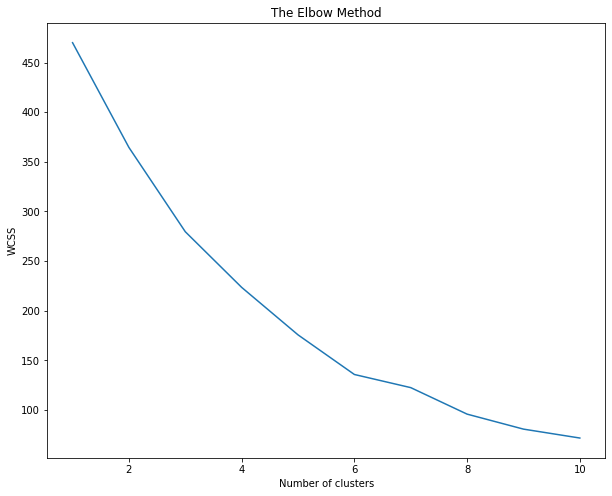

In [185]:

#K-Means Clustering
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(dataset_standarized)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [186]:
# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 6, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(dataset_standarized)
#beginning of  the cluster numbering with 1 instead of 0
y_kmeans1=y_kmeans
y_kmeans1=y_kmeans+1
# New Dataframe called cluster
kmeans_cluster = pd.DataFrame(y_kmeans1)
# Adding cluster to the Dataset1
df['kmeans_cluster'] = kmeans_cluster
#Mean of clusters
kmeans_mean_cluster = pd.DataFrame(round(df.groupby('kmeans_cluster').mean(),1))
kmeans_mean_cluster

C:\Users\miguel.torres\.conda\envs\spyder\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,Grocery Store,Park,Bank,Gym / Fitness Center,Liquor Store
kmeans_cluster,,,,,
1,0.2,1.2,0.0,0.0,0.0
2,0.1,0.0,0.0,0.0,0.0
3,0.5,0.6,0.3,0.0,1.0
4,0.1,0.8,0.4,1.0,0.0
5,3.5,2.0,0.5,0.5,0.5
6,0.3,0.2,1.2,0.0,0.2


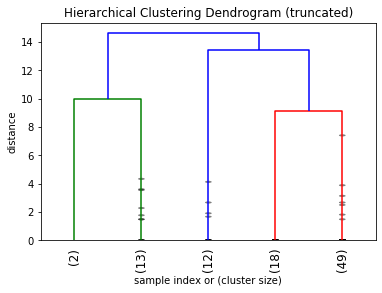

In [187]:
#Hierarchical Clustering
# Hierarchical clustering for the same dataset
# creating a dataset for hierarchical clustering
dataset2_standarized = dataset_standarized
# needed imports

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
# some setting for this notebook to actually show the graphs inline
# you probably won't need this
%matplotlib inline
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation
#creating the linkage matrix
H_cluster = linkage(dataset2_standarized,'ward')
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    H_cluster,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=5,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

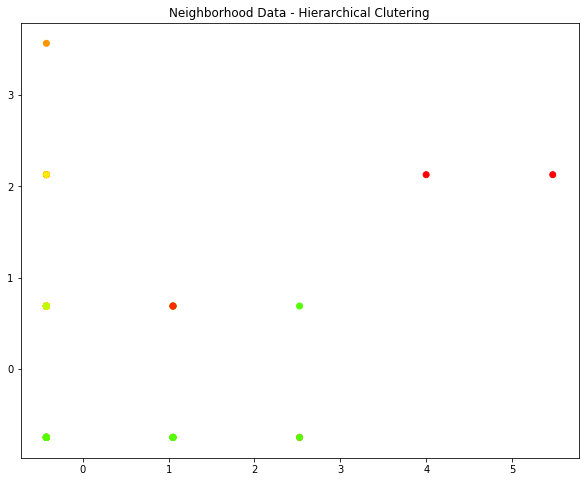

In [188]:
# Assigning the clusters and plotting the observations as per hierarchical clustering
from scipy.cluster.hierarchy import fcluster
k=6
hierarchical_cluster = fcluster(H_cluster, k, criterion='maxclust')
hierarchical_cluster[0:30:,]
plt.figure(figsize=(10, 8))
plt.scatter(dataset2_standarized.iloc[:,0], dataset2_standarized.iloc[:,1],c=hierarchical_cluster, cmap='prism')  # plot points with cluster dependent colors
plt.title('Neighborhood Data - Hierarchical Clutering')
plt.show()

In [189]:
# Assigning the clusters and plotting the observations as per hierarchical clustering
from scipy.cluster.hierarchy import fcluster
k=6
cluster_2 = fcluster(H_cluster, k, criterion='maxclust')
cluster_2[0:30:,]

# New Dataframe called cluster
cluster_Hierarchical = pd.DataFrame(cluster_2)
# Adding the hierarchical clustering to dataset
df['hierarchical_cluster'] = cluster_Hierarchical
df.head()

C:\Users\miguel.torres\.conda\envs\spyder\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,Neighborhood,Grocery Store,Park,Bank,Gym / Fitness Center,Liquor Store,kmeans_cluster,hierarchical_cluster
0,Agincourt,0,0,0,0,0,2,6
1,"Alderwood , Long Branch",0,0,0,0,0,2,6
2,"Bathurst Manor , Wilson Heights , Downsview North",0,0,2,0,0,6,5
3,Bayview Village,0,0,1,0,0,6,5
4,"Bedford Park , Lawrence Manor East",1,0,0,0,1,3,2


In [190]:
df[df['Neighborhood']=='Downsview']

,Neighborhood,Grocery Store,Park,Bank,Gym / Fitness Center,Liquor Store,kmeans_cluster,hierarchical_cluster
24,Downsview,3,2,1,1,1,5,1


In [192]:
df[df['kmeans_cluster']==5]

,Neighborhood,Grocery Store,Park,Bank,Gym / Fitness Center,Liquor Store,kmeans_cluster,hierarchical_cluster
14,Christie,4,2,0,0,0,5,1
24,Downsview,3,2,1,1,1,5,1


In [193]:
df[df['hierarchical_cluster']==1]

,Neighborhood,Grocery Store,Park,Bank,Gym / Fitness Center,Liquor Store,kmeans_cluster,hierarchical_cluster
14,Christie,4,2,0,0,0,5,1
24,Downsview,3,2,1,1,1,5,1


# Conclusion 

In this study, I analyzed the the neighborhoods within Toronto metropolitan area. Based on Miguel's venues preferences, I built Hierarchichal and Knn classification models  to predict whether a neighborhood is similar or not to what Miguel wants. These models were very useful to classify the neighborhoods. In this case Miguel found the neighborhood that with the closest match to his neighborhood given his initial preferences.